In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [2]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/ribe_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);
VV = _load_jld(VV_files[[1,4]],data_folder);
VH = _load_jld(VH_files[[1,4]],data_folder);

In [9]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/ribe_new/flood"
figure_folder = "/Users/simon/Documents/DTU fag/Speciale/Figures_repport/HSBA_ribe"

VV = [JLD.load(joinpath(data_folder,"VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VV_pre_median.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"VH_pre_median.jld"),"data")];


In [10]:
threshold_indx = 3

3

## VV

In [11]:
co = VV[1][end:-1:1,:]
pre = VV[2][end:-1:1,:];

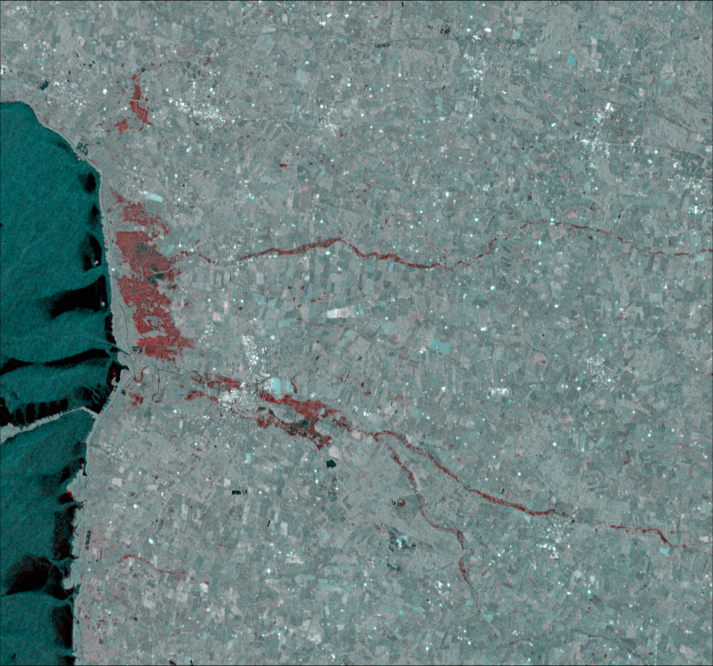

In [5]:
imgVV = pretty_img([co,pre],min_vv,max_vv)

In [6]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [7]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


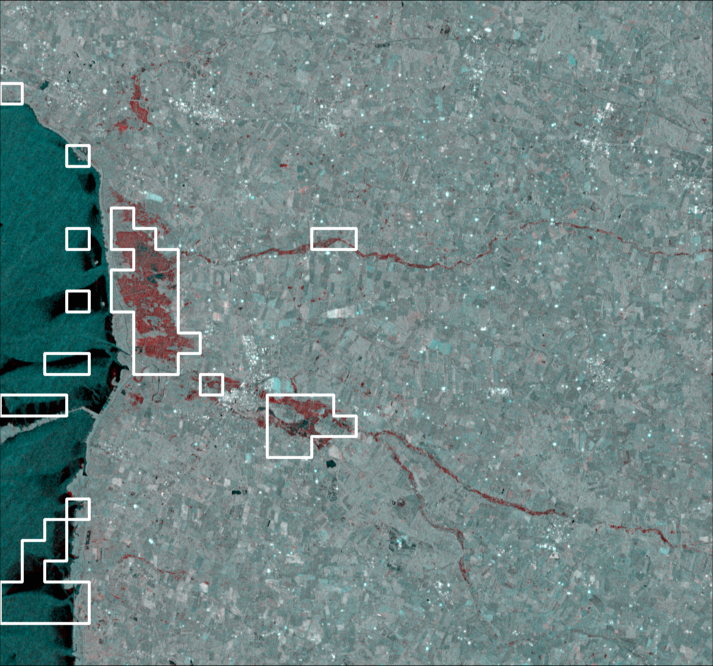

In [13]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVV,subset_edges,(1,1,1))

file_path = joinpath(figure_folder,"tile_select_median")
FileIO.save(file_path*".png",img_save)
img_save

In [120]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;



In [15]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3);


Iterration : 1
x_i: [-12.65, -1.0], f_i: 0.00013639885465942519
dfdx: [0.0, 0.0]

Iterration : 2
x_i: [-12.65, -1.0], f_i: 0.00013639885465942519
dfdx: [0.0, -3.13093e-5]
Step x, step_idx:5,  no_step: -2

Iterration : 3
x_i: [-12.65, 30.3093], f_i: 9.564768225779816e-5
dfdx: [-4.52196e-5, 0.0]
Step x, step_idx:3,  no_step: -2

Iterration : 4
x_i: [-12.1978, 30.3093], f_i: 8.259402112681136e-5
dfdx: [-1.50945e-5, 0.0]
Step x, step_idx:3,  no_step: -2

Iterration : 5
x_i: [-12.0469, 30.3093], f_i: 8.086440703703058e-5
dfdx: [-8.4425e-6, 0.0]
Step x, step_idx:3,  no_step: -2

Iterration : 6
x_i: [-11.9624, 30.3093], f_i: 8.037210224943624e-5
dfdx: [1.79915e-5, 0.0]
Step x, step_idx:1,  no_step: -2

Iterration : 7
x_i: [-11.9642, 30.3093], f_i: 8.037049181786987e-5
dfdx: [1.79915e-5, -5.93385e-7]
No change, Decrease delta, no_step: -1

Iterration : 8
x_i: [-11.9642, 30.3093], f_i: 8.037049181786987e-5
dfdx: [-2.63442e-6, -5.93385e-7]
Step x, step_idx:3,  no_step: -1

Iterration : 9
x_i: [

In [16]:
thresholds3, f3

([-11.9484, 30.3153], 8.016653120559036e-5)

In [17]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([-11.9103, 10.4847], 8.005983251785503e-5)

In [18]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-11.9104, 1.99074], 0.00010040156486329263)

In [19]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx];

In [51]:
[x for x=1:3]

3-element Array{Int64,1}:
 1
 2
 3

In [139]:


test_sigma = collect(LinRange(-13,-8,20))
test_dsigma = collect(LinRange(-2,3,20))

20-element Array{Float64,1}:
 -2.0                
 -1.736842105263158  
 -1.473684210526316  
 -1.2105263157894737 
 -0.9473684210526316 
 -0.6842105263157896 
 -0.42105263157894746
 -0.1578947368421053 
  0.10526315789473673
  0.36842105263157876
  0.631578947368421  
  0.8947368421052633 
  1.157894736842105  
  1.4210526315789476 
  1.6842105263157892 
  1.9473684210526314 
  2.2105263157894735 
  2.473684210526316  
  2.7368421052631575 
  3.0                

In [140]:
loss = [sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [r1,r2])
    for r1=test_sigma, r2=test_dsigma];

In [141]:
[[r1,r2]
    for r1=test_sigma, r2=test_dsigma]

20×20 Array{Array{Float64,1},2}:
 [-13.0, -2.0]     [-13.0, -1.73684]     …  [-13.0, 3.0]   
 [-12.7368, -2.0]  [-12.7368, -1.73684]     [-12.7368, 3.0]
 [-12.4737, -2.0]  [-12.4737, -1.73684]     [-12.4737, 3.0]
 [-12.2105, -2.0]  [-12.2105, -1.73684]     [-12.2105, 3.0]
 [-11.9474, -2.0]  [-11.9474, -1.73684]     [-11.9474, 3.0]
 [-11.6842, -2.0]  [-11.6842, -1.73684]  …  [-11.6842, 3.0]
 [-11.4211, -2.0]  [-11.4211, -1.73684]     [-11.4211, 3.0]
 [-11.1579, -2.0]  [-11.1579, -1.73684]     [-11.1579, 3.0]
 [-10.8947, -2.0]  [-10.8947, -1.73684]     [-10.8947, 3.0]
 [-10.6316, -2.0]  [-10.6316, -1.73684]     [-10.6316, 3.0]
 [-10.3684, -2.0]  [-10.3684, -1.73684]  …  [-10.3684, 3.0]
 [-10.1053, -2.0]  [-10.1053, -1.73684]     [-10.1053, 3.0]
 [-9.84211, -2.0]  [-9.84211, -1.73684]     [-9.84211, 3.0]
 [-9.57895, -2.0]  [-9.57895, -1.73684]     [-9.57895, 3.0]
 [-9.31579, -2.0]  [-9.31579, -1.73684]     [-9.31579, 3.0]
 [-9.05263, -2.0]  [-9.05263, -1.73684]  …  [-9.05263, 3.0]
 [-8.78

In [142]:
minimum(loss)

9.929301349862401e-5

In [143]:
loss

20×20 Array{Float64,2}:
 0.000167826  0.000162194  0.000156162  …  0.000134595  0.000134409
 0.000162851  0.000156017  0.000148568     0.000119334  0.000119084
 0.000160216  0.000152473  0.000144179     0.000108946  0.000108672
 0.000158753  0.000150428  0.000141507     0.000102426  0.000102178
 0.00015801   0.000149377  0.000139983     9.94642e-5   9.9293e-5  
 0.000157563  0.000148797  0.000139195  …  0.000100159  0.000100138
 0.00015733   0.000148482  0.000138775     0.000105028  0.000105235
 0.000157214  0.000148317  0.000138579     0.000113845  0.000114445
 0.000157161  0.000148241  0.000138463     0.000129404  0.000130686
 0.000157124  0.000148196  0.000138405     0.000151193  0.000153917
 0.000157108  0.000148171  0.000138377  …  0.000180068  0.000184314
 0.000157103  0.000148162  0.000138365     0.000215536  0.000222214
 0.0001571    0.000148159  0.00013836      0.000255216  0.000265282
 0.0001571    0.000148158  0.000138359     0.000293737  0.000307681
 0.0001571    0.00014815

In [144]:
maximum(loss)

0.0004762484276154785

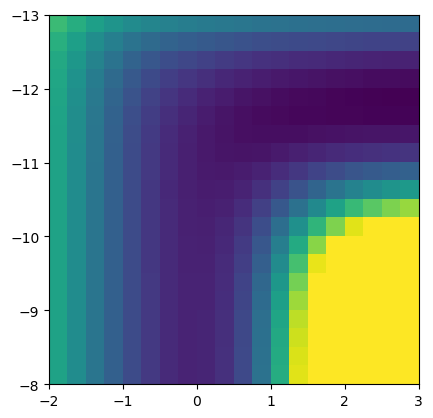

PyObject <matplotlib.image.AxesImage object at 0x144bb39e8>

In [150]:
PyPlot.figure(0.001)
PyPlot.imshow(loss,vmin=0.0000992,vmax=0.0002
    ,extent=[test_dsigma[1],test_dsigma[end],test_sigma[end],test_sigma[1]])

In [20]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [21]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

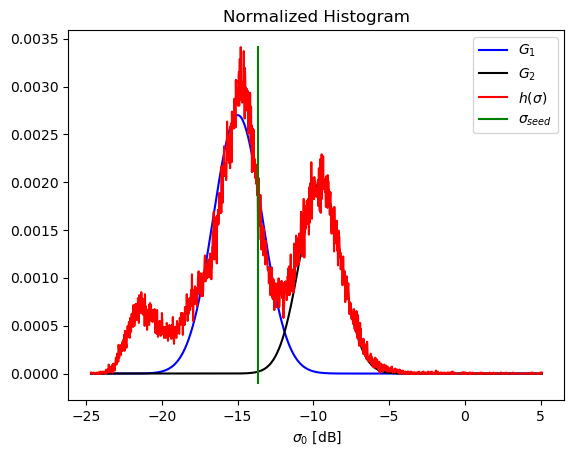

In [37]:
file_path = joinpath(figure_folder,"histogram_tiles.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="g")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

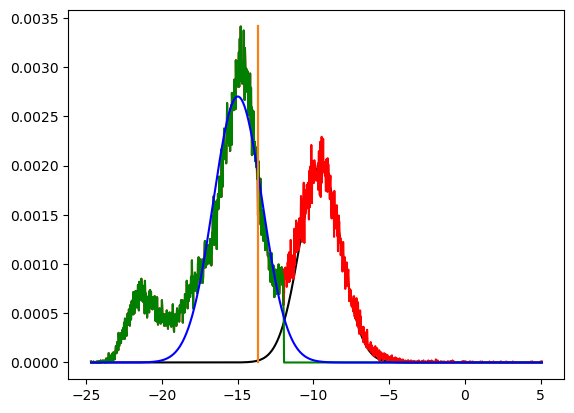

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13ba9d198>

In [22]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
#PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

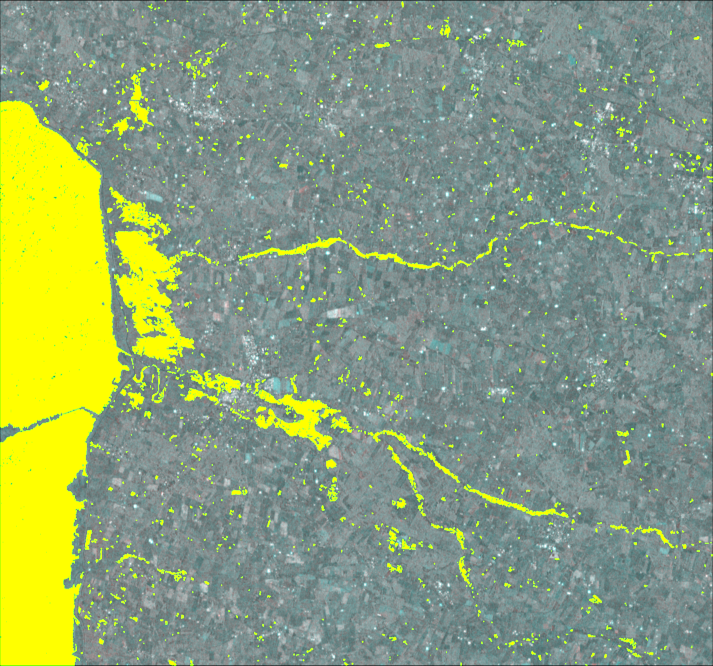

In [38]:
add_mask(imgVV,flood_mask,(1,2,0))

In [39]:
rg_thresholds

2-element Array{Float64,1}:
 -11.948387497746252
  30.3152732941629  

In [40]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

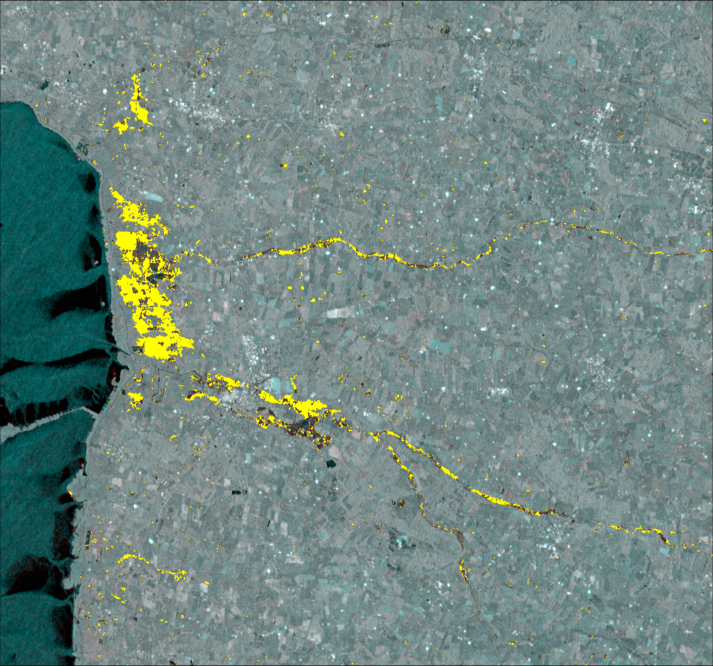

In [41]:
add_mask(imgVV,final_mask,(1,1,0))

## VH

In [60]:
co = VH[1][end:-1:1,:]
pre = VH[2][end:-1:1,:];

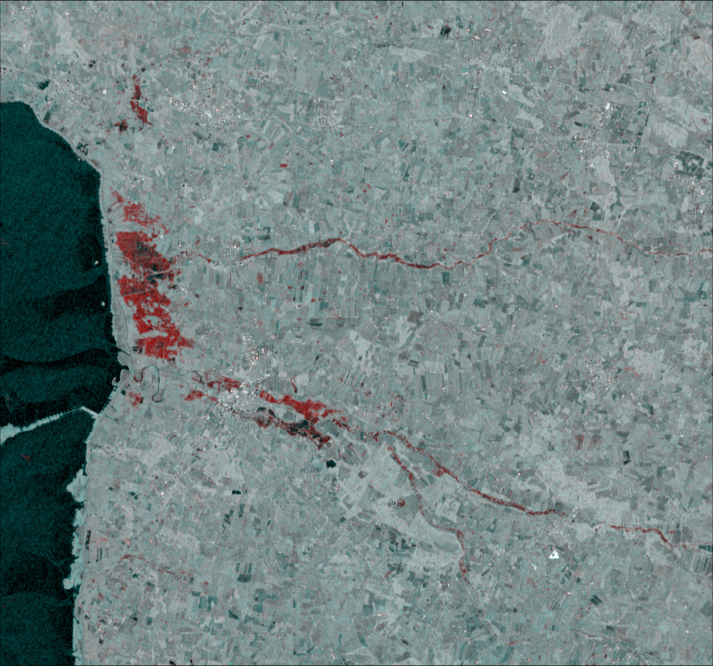

In [61]:
imgVH = pretty_img([co,pre],min_vh,max_vh)

In [62]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [63]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


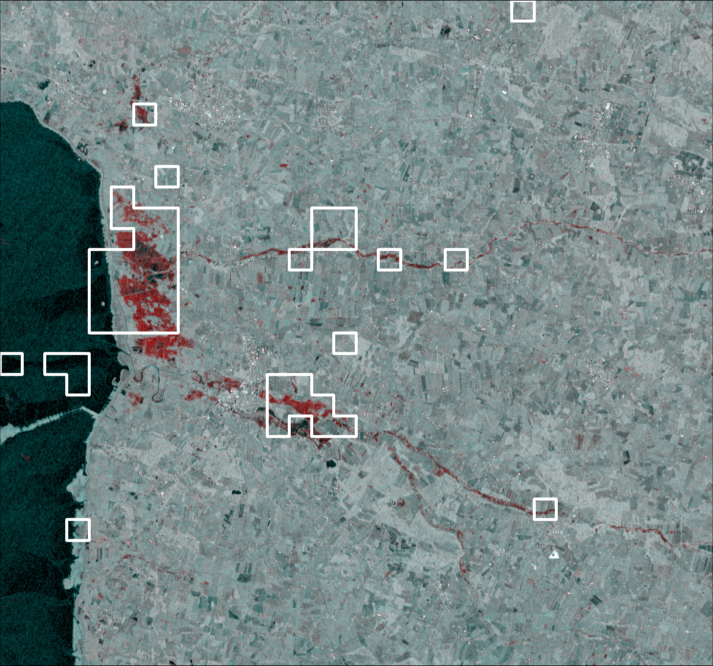

In [64]:
subset_edges = get_edges(bm_mask);
add_mask(imgVH,subset_edges,(1,1,1))

In [65]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;

In [66]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3)


Iterration : 1
x_i: [-21.37, -1.0], f_i: 1.1876458949624054e-5
dfdx: [0.0, 0.0]

Iterration : 2
x_i: [-21.37, -1.0], f_i: 1.1876458949624054e-5
dfdx: [-1.06712e-5, 0.0]
Step x, step_idx:3,  no_step: -2

Iterration : 3
x_i: [-21.2633, -1.0], f_i: 1.1113098659998093e-5
dfdx: [-1.64454e-6, -4.84459e-8]
Step x, step_idx:4,  no_step: -2

Iterration : 4
x_i: [-21.0988, -0.995155], f_i: 1.0210041692870746e-5
dfdx: [-4.43383e-6, -3.7848e-7]
Step x, step_idx:3,  no_step: -2

Iterration : 5
x_i: [-21.0545, -0.991371], f_i: 9.999689817427872e-6
dfdx: [-6.70281e-6, -3.95208e-7]
Step x, step_idx:3,  no_step: -2

Iterration : 6
x_i: [-20.9875, -0.987419], f_i: 9.803505453823393e-6
dfdx: [-6.85718e-7, -1.51723e-6]
Step x, step_idx:4,  no_step: -2

Iterration : 7
x_i: [-20.9189, -0.835695], f_i: 9.693394826154581e-6
dfdx: [-5.42453e-8, -1.50988e-7]
Step x, step_idx:4,  no_step: -2

Iterration : 8
x_i: [-20.9135, -0.820596], f_i: 9.645090593160982e-6
dfdx: [-5.25336e-9, -1.5128e-8]
Step x, step_idx:5,

9.63303192700177e-6

In [67]:
thresholds3, f3

([-20.9082, -0.805469], 9.63303192700177e-6)

In [68]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([-20.8287, -0.952686], 9.66400949738343e-6)

In [69]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-21.0359, 0.0570591], 9.730769887116458e-6)

In [70]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx]

2-element Array{Float64,1}:
 -20.90821810469669  
  -0.8054685010012834

In [71]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [72]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

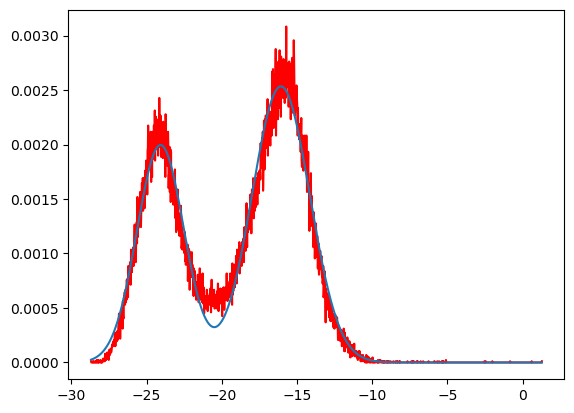

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x146963dd8>

In [73]:
PyPlot.figure()
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )


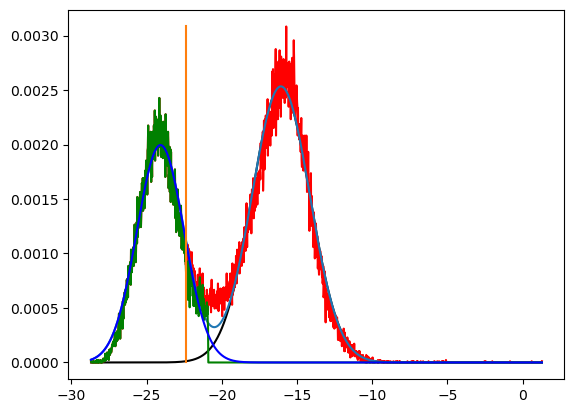

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x146fccda0>

In [74]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

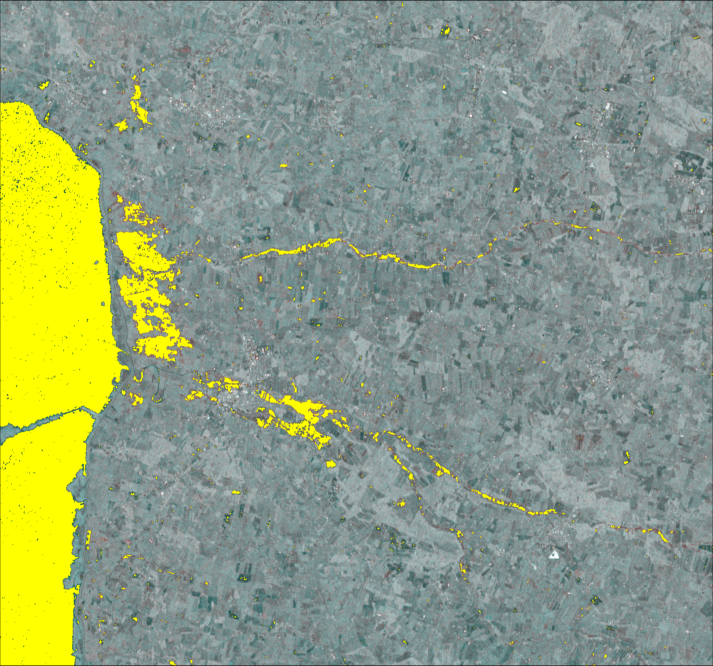

In [75]:
add_mask(imgVH,flood_mask,(1,1,0))

In [76]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

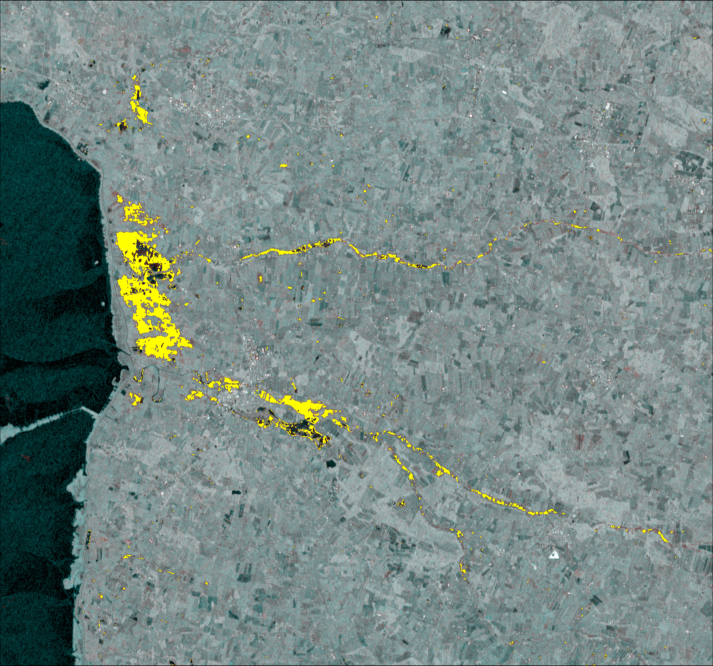

In [77]:
add_mask(imgVH,final_mask,(1,1,0))